In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pprint import pprint

import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.datasets.factory import make_dataset


from hydra import compose, initialize
from omegaconf import OmegaConf

# context initialization
with initialize(version_base=None, config_path="../configs", job_name="test_app"):
    cfg = compose(config_name="default")
    print(OmegaConf.to_yaml(cfg))

/home/j/workspace/lerobot/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


resume: false
device: cuda
use_amp: false
seed: 100000
dataset_repo_id: lerobot/pusht
video_backend: pyav
training:
  offline_steps: 200000
  num_workers: 4
  batch_size: 64
  eval_freq: 25000
  log_freq: 200
  save_checkpoint: true
  save_freq: 25000
  online_steps: 0
  online_rollout_n_episodes: 1
  online_rollout_batch_size: 1
  online_steps_between_rollouts: 1
  online_sampling_ratio: 0.5
  online_env_seed: null
  online_buffer_capacity: null
  online_buffer_seed_size: 0
  do_online_rollout_async: false
  image_transforms:
    enable: false
    max_num_transforms: 3
    random_order: false
    brightness:
      weight: 1
      min_max:
      - 0.8
      - 1.2
    contrast:
      weight: 1
      min_max:
      - 0.8
      - 1.2
    saturation:
      weight: 1
      min_max:
      - 0.5
      - 1.5
    hue:
      weight: 1
      min_max:
      - -0.05
      - 0.05
    sharpness:
      weight: 1
      min_max:
      - 0.8
      - 1.2
  grad_clip_norm: 10
  lr: 0.0001
  lr_scheduler: c

In [3]:
# get the path to the dataset
import pandas as pd
import numpy as np
from pathlib import Path
env_name = 'pusht' # 'pinpad' # 'robosuite'

# base_path = Path(f"~/workspace/lerobot/local/{env_name}/original").expanduser()
# base_path = Path(f"~/workspace/fastrl/logs/HD_pinpad_four_1/a").expanduser()
imi = 7
AI = True

def get_files(env_name, imi, AI=False):
    if AI:
        base_path = Path(f"~/workspace/fastrl/logs/AD_pusht_{imi}/").expanduser()
        out_dir = Path(f"~/workspace/lerobot/local/{env_name}/A{imi}").expanduser()
    else:
        base_path = Path(f"~/workspace/fastrl/logs/HD_pusht_{imi}/").expanduser()
        out_dir = Path(f"~/workspace/lerobot/local/{env_name}/{imi}").expanduser()

# list all the files in the dataset
    folders = list(base_path.glob("*"))

    files = []
    for f in folders:
        files.extend((base_path / f).glob("*"))
    return files, out_dir

files, out_dir = get_files(env_name, imi, AI=AI)

print(files)

# print the keys
data = np.load(files[0])
# convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
data = dict(data)
for k,v in data.items():
    print(k, v.shape)

# print("Setting last is_terminal to true")
# data["is_terminal"][-1] = True; data['is_last'][-1] = True

[PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000036-a7db0fcfc37c4662a73a2d5fb4b7a675-57.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000018-19d0edad68584006892948523a58b976-47.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000036-5fdc796bb96445f18591238b305c5965-301.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000013-59336ccee68a49cba209f9c6f362bdbe-55.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000026-282d51313d674b469f44f4527957abd3-132.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000012-ccc02a021a2d47789ca14cb9b07bdafc-133.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000028-7400940190c747989fa51acdb1c660a0-301.npz'), PosixPath('/home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000040-573d1d08b531460fa915e3005f65f201-73.npz'), PosixPath('/home/j/workspac

In [10]:
import tqdm
import torch
import einops
import shutil
from PIL import Image as PILImage
import cv2

from lerobot.common.datasets.push_dataset_to_hub.utils import concatenate_episodes, save_images_concurrently
from lerobot.common.datasets.compute_stats import compute_stats
from lerobot.scripts.push_dataset_to_hub import save_meta_data
from lerobot.common.datasets.video_utils import VideoFrame, encode_video_frames
from lerobot.common.datasets.utils import hf_transform_to_torch
from datasets import Dataset, Features, Image, Sequence, Value

def to_hf_dataset(data_dict, video):
    features = {}

    if video:
        features["observation.image"] = VideoFrame()
    else:
        features["observation.image"] = Image()

    features["observation.state"] = Sequence(
        length=data_dict["observation.state"].shape[1], feature=Value(dtype="float32", id=None)
    )
    features["action"] = Sequence(
        length=data_dict["action"].shape[1], feature=Value(dtype="float32", id=None)
    )
    features["episode_index"] = Value(dtype="int64", id=None)
    features["frame_index"] = Value(dtype="int64", id=None)
    features["timestamp"] = Value(dtype="float32", id=None)
    features["next.reward"] = Value(dtype="float32", id=None)
    features["next.done"] = Value(dtype="bool", id=None)
    features["index"] = Value(dtype="int64", id=None)
    # TODO(rcadene): add success
    # features["next.success"] = Value(dtype='bool', id=None)

    hf_dataset = Dataset.from_dict(data_dict, features=Features(features))
    hf_dataset.set_transform(hf_transform_to_torch)
    return hf_dataset

def files_to_data_dict(files):
    data_dicts = []
    for data_fn in files:
        print(f"Processing {data_fn}")
        data = np.load(data_fn)
        data = dict(data); 
        data["is_terminal"][-1] = True
        data_dicts.append(data)
    big_data_dict = {}
    for k in data_dicts[0].keys():
        big_data_dict[k] = np.concatenate([d[k] for d in data_dicts], axis=0)
        print(k, big_data_dict[k].shape)
        if 'reward' in big_data_dict:
            for kk in ['reward', 'is_terminal', 'is_last']:
                print(f"{kk} {sum(big_data_dict[kk])}")
    return big_data_dict

big_data_dict = files_to_data_dict(files)

Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000036-a7db0fcfc37c4662a73a2d5fb4b7a675-57.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000018-19d0edad68584006892948523a58b976-47.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000036-5fdc796bb96445f18591238b305c5965-301.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000013-59336ccee68a49cba209f9c6f362bdbe-55.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000026-282d51313d674b469f44f4527957abd3-132.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000012-ccc02a021a2d47789ca14cb9b07bdafc-133.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000028-7400940190c747989fa51acdb1c660a0-301.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/final_eps/20240802T000040-573d1d08b531460fa915e3005f65f201-73.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_7/

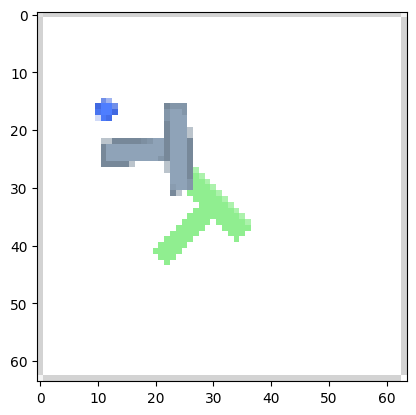

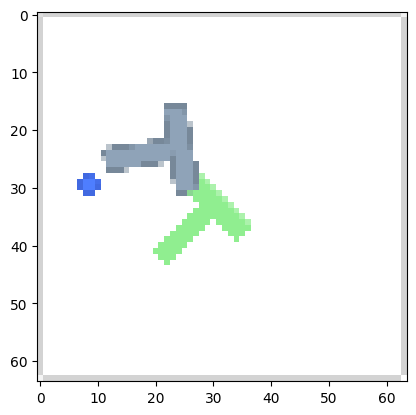

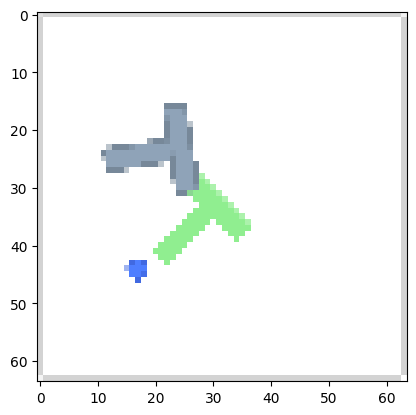

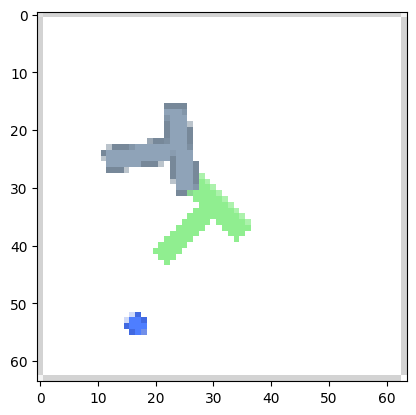

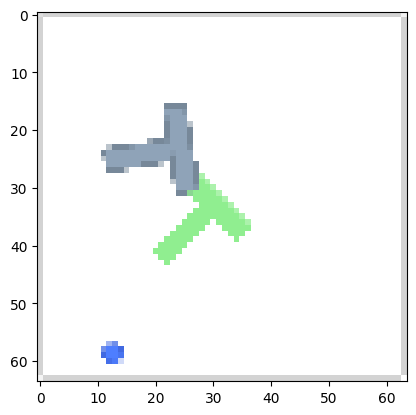

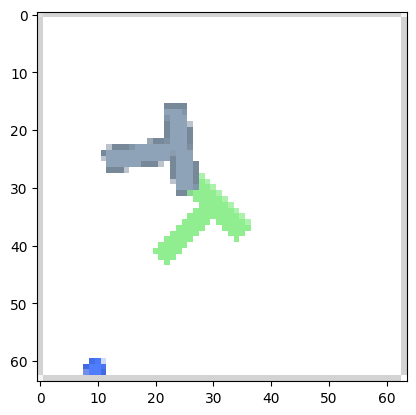

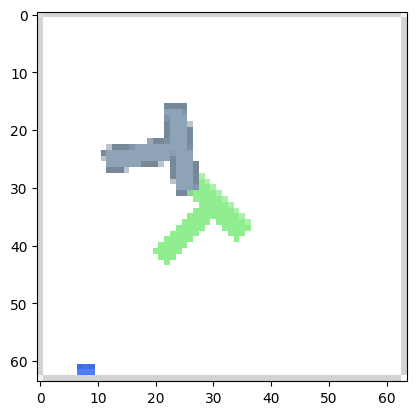

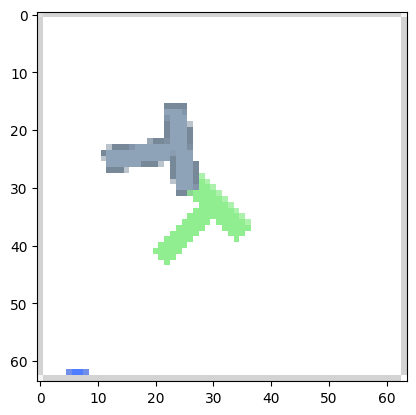

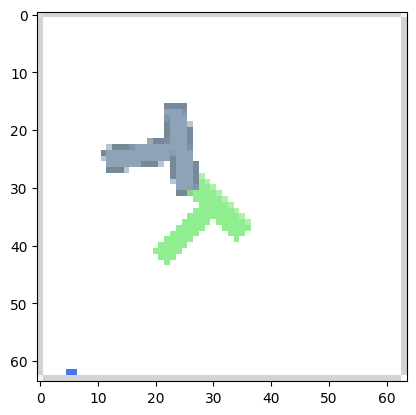

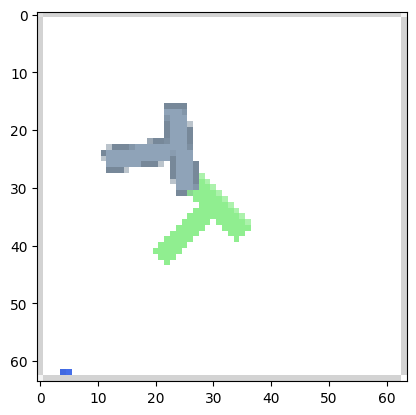

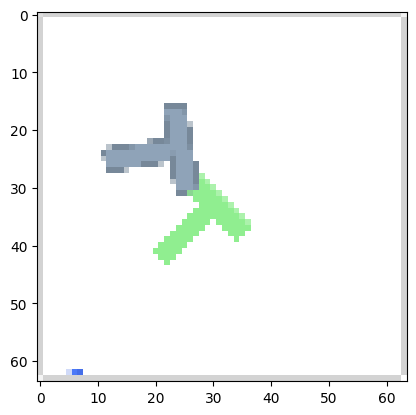

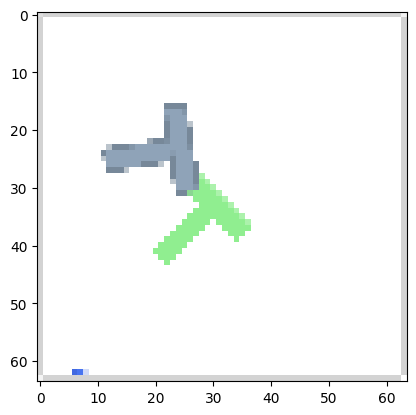

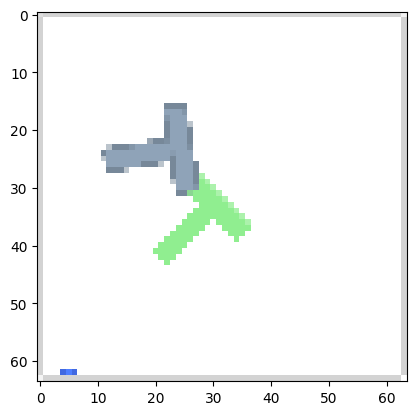

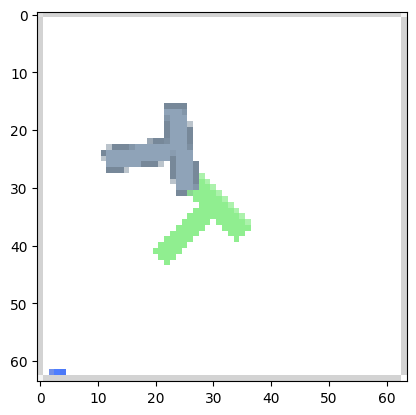

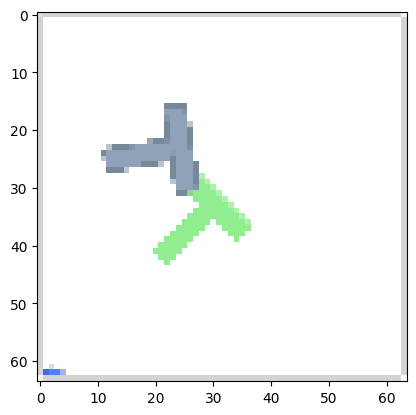

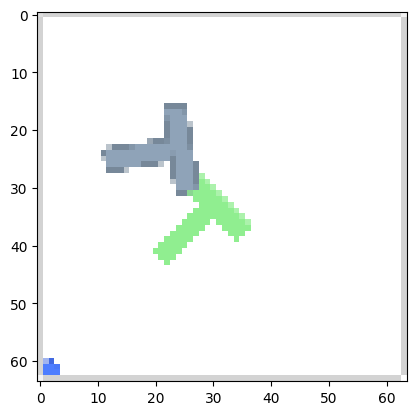

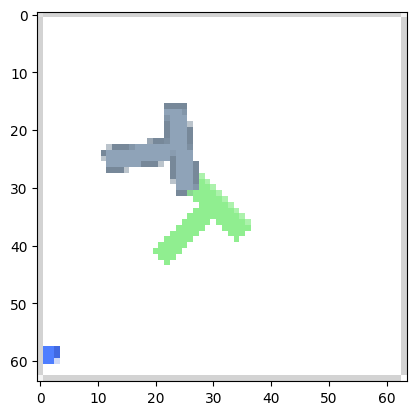

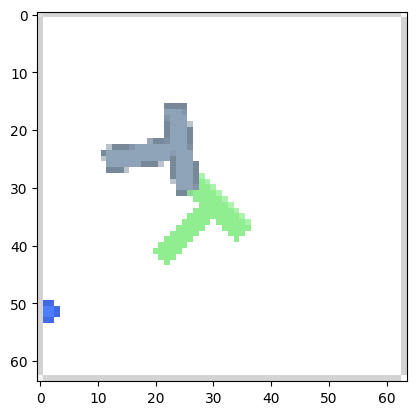

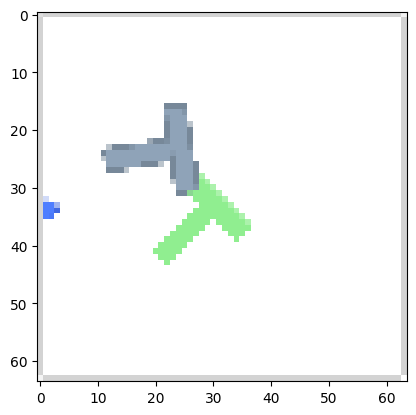

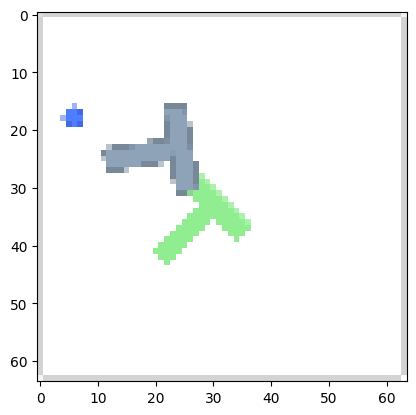

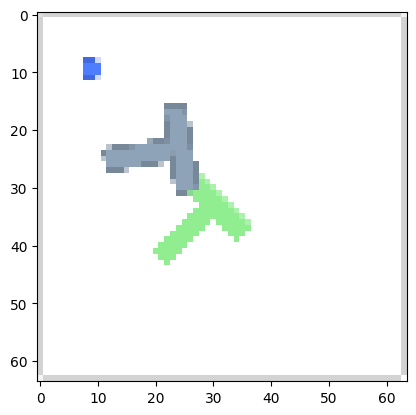

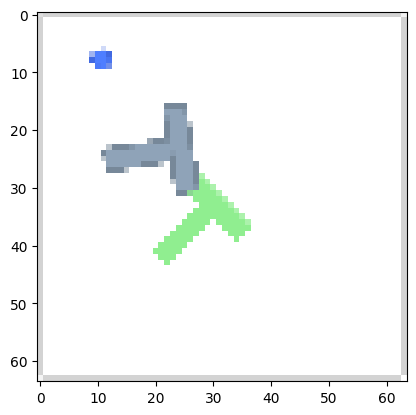

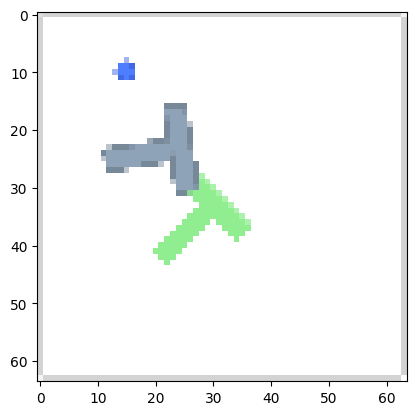

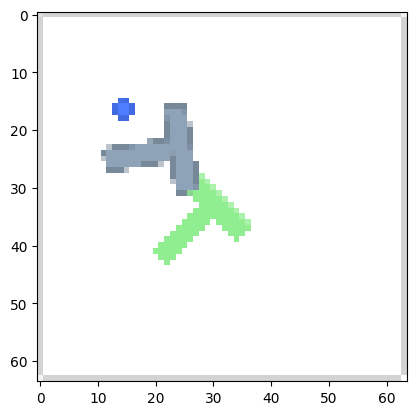

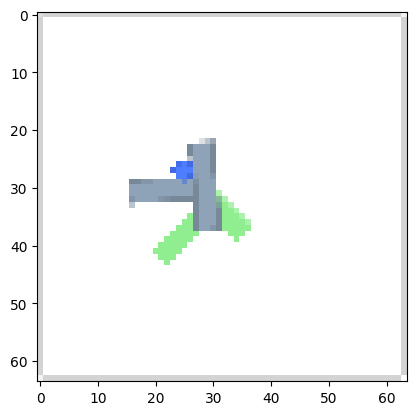

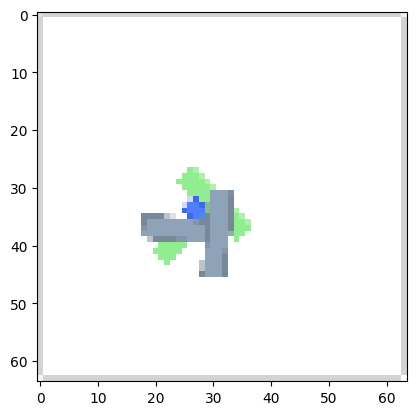

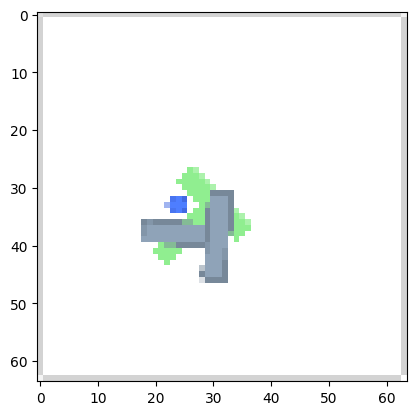

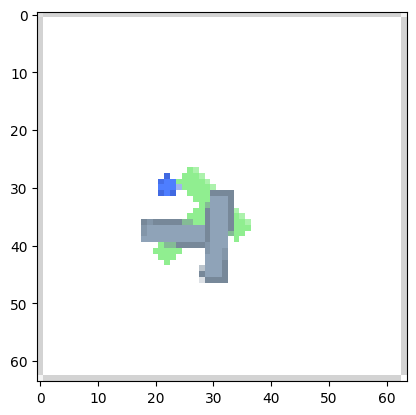

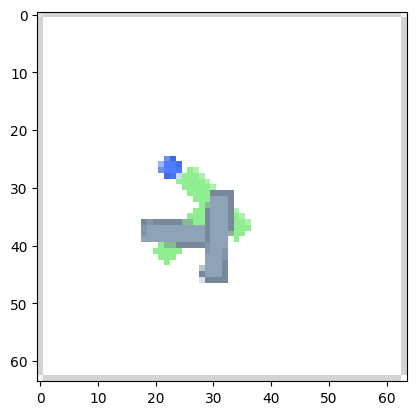

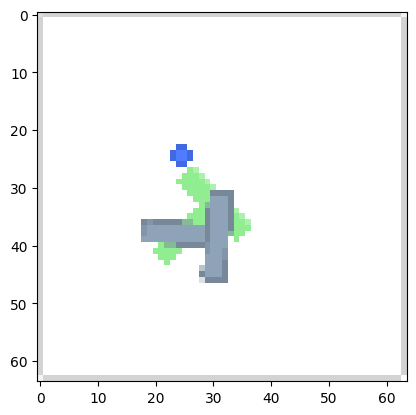

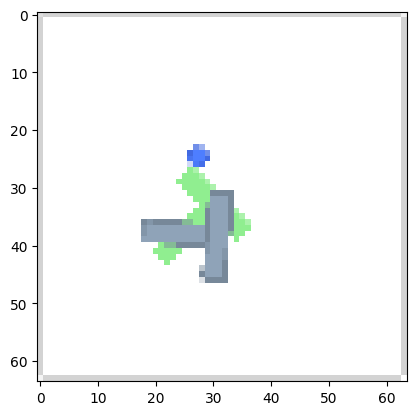

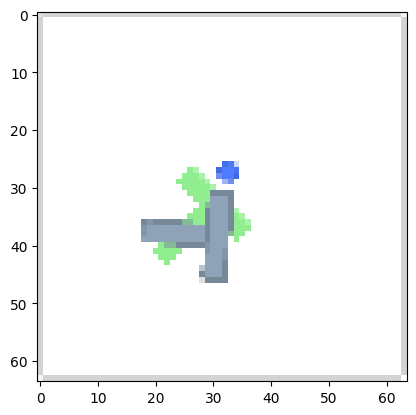

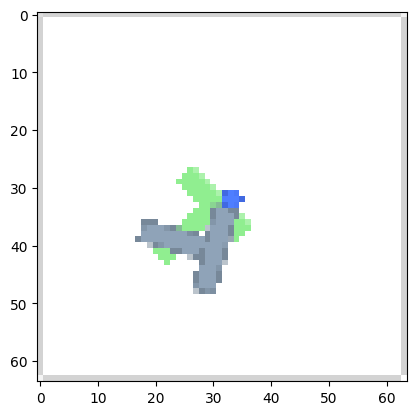

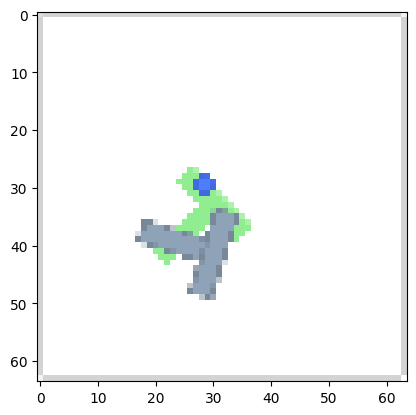

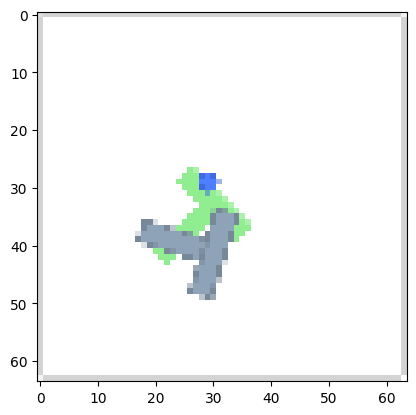

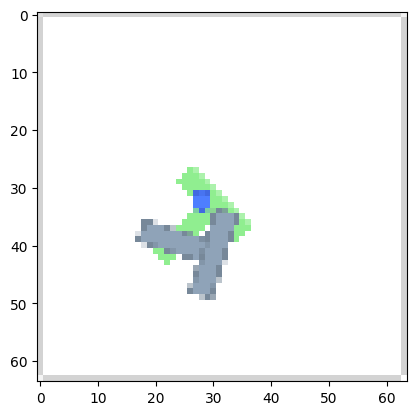

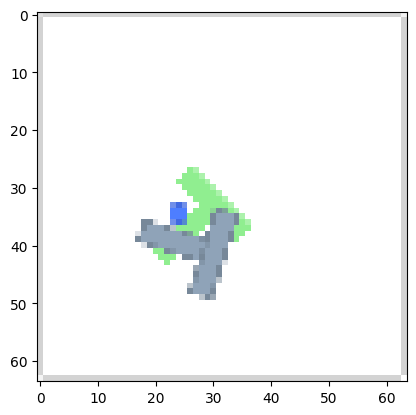

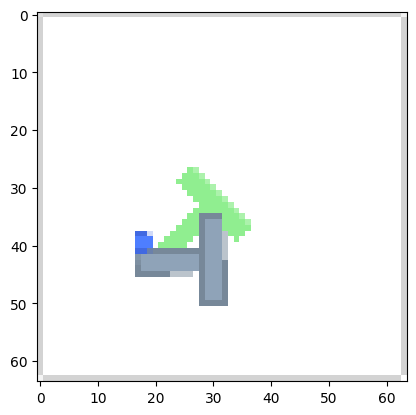

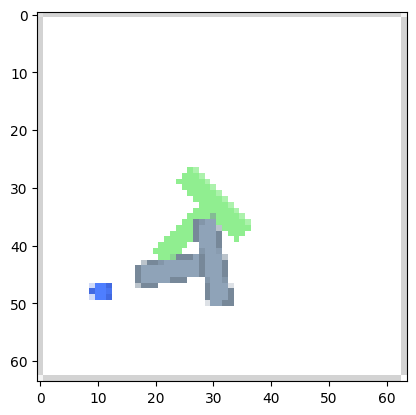

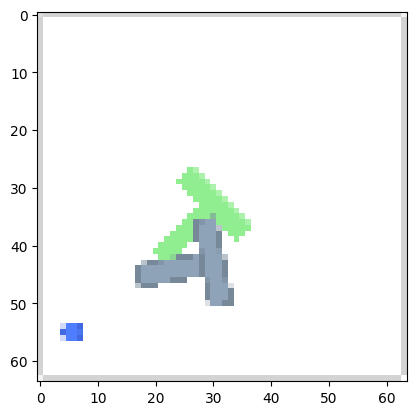

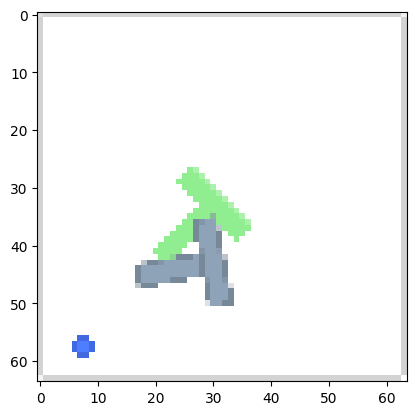

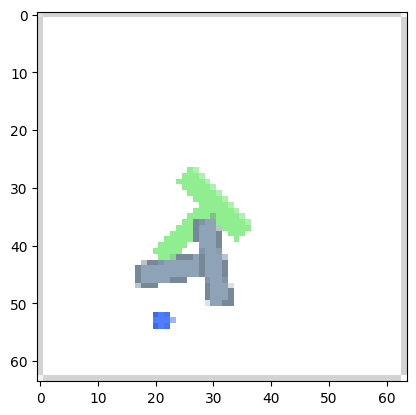

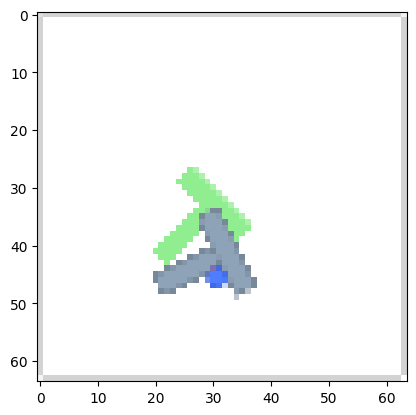

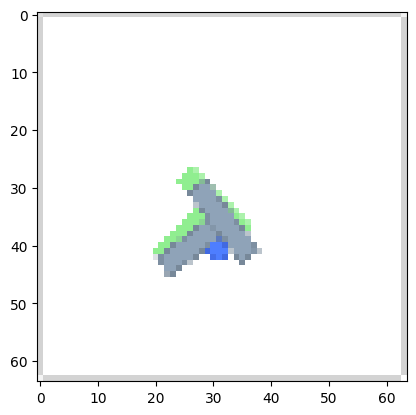

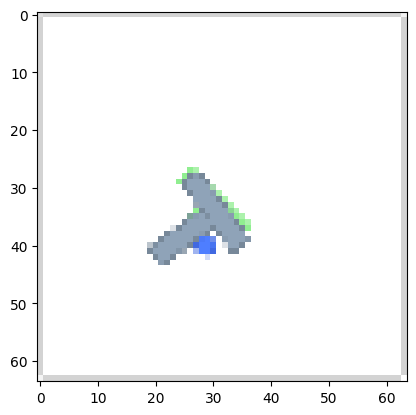

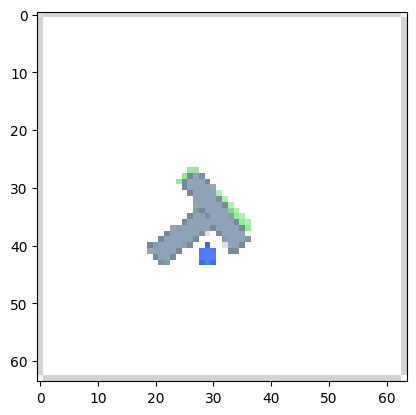

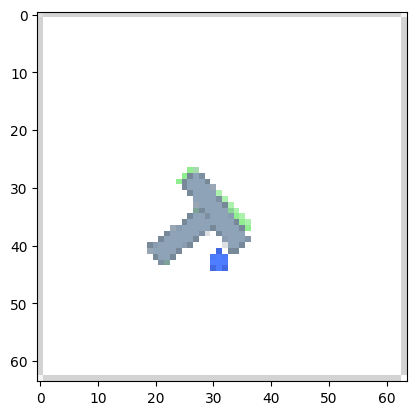

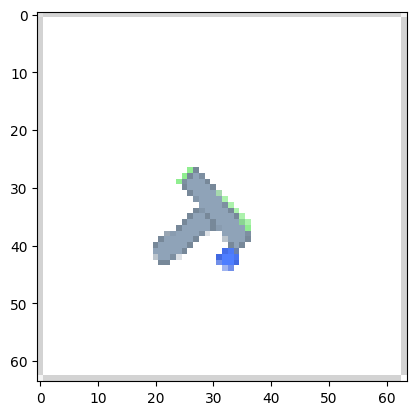

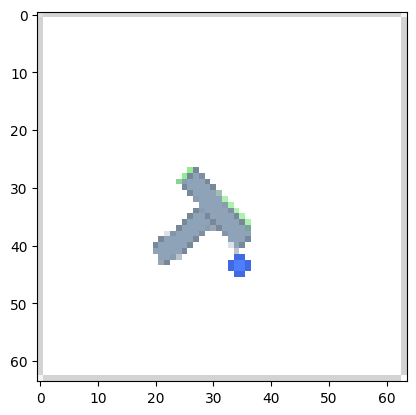

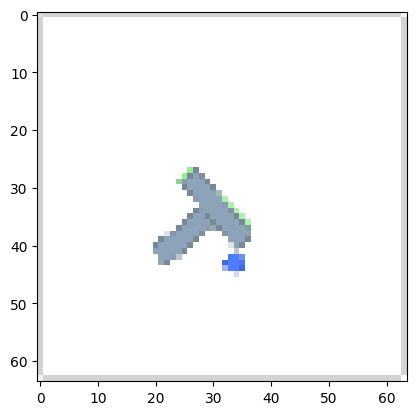

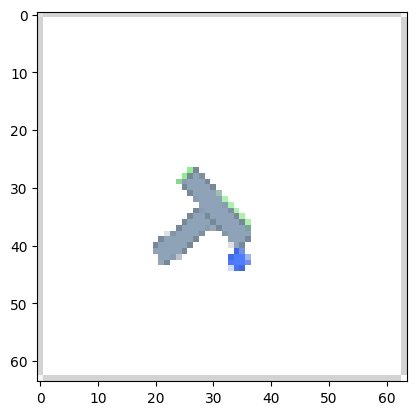

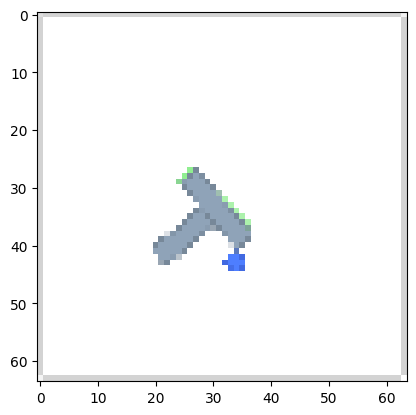

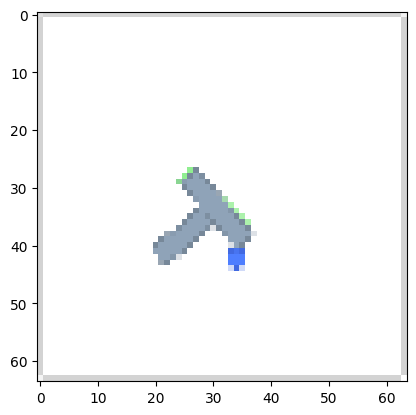

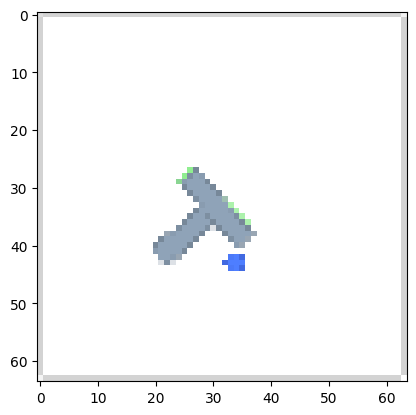

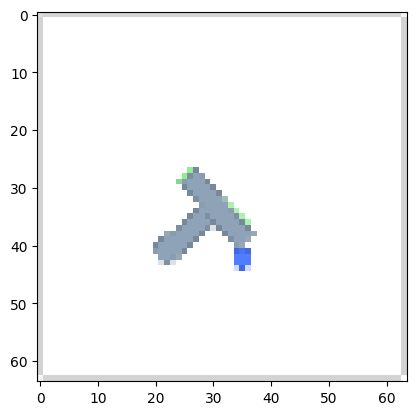

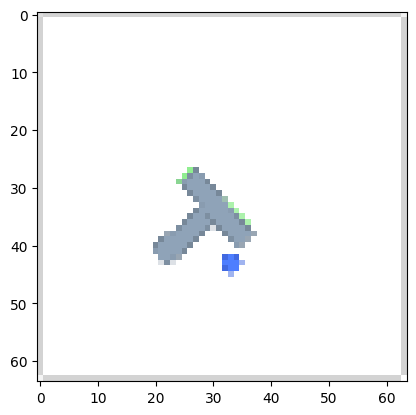

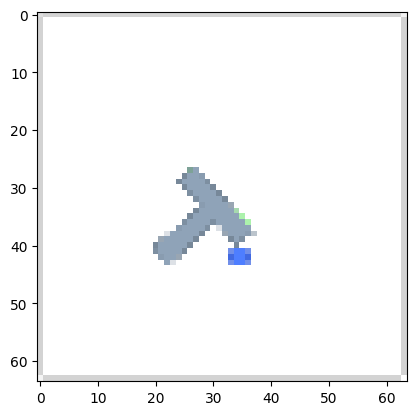

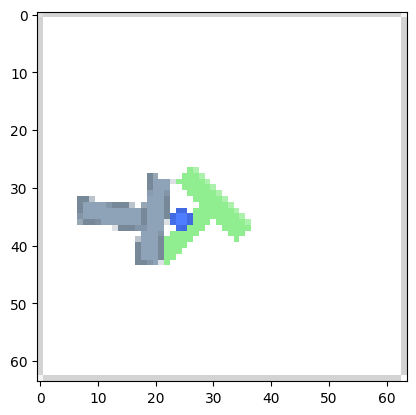

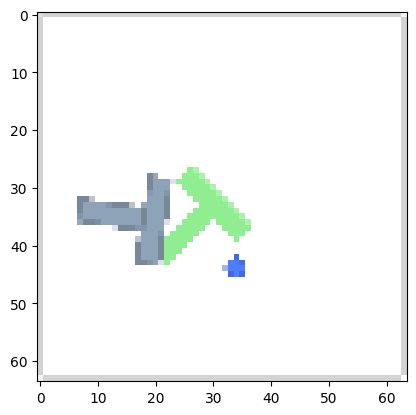

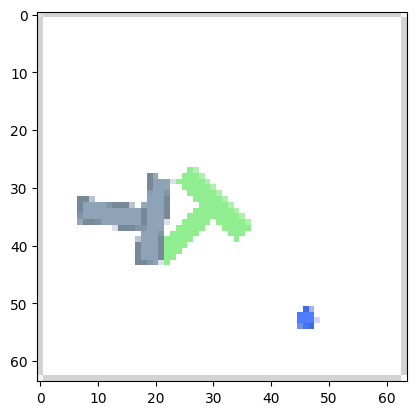

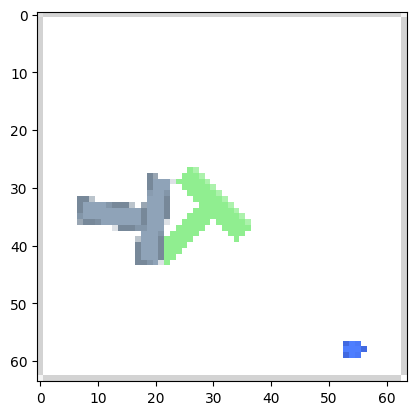

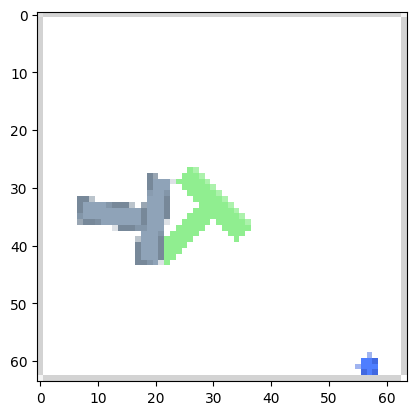

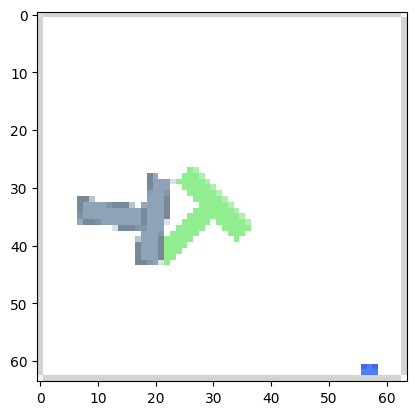

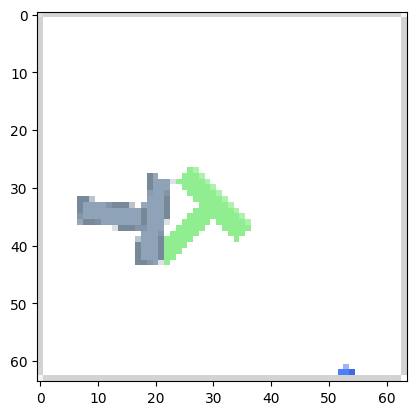

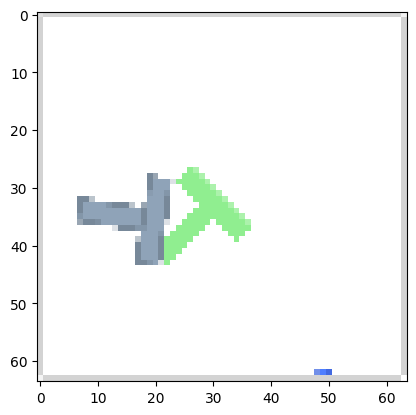

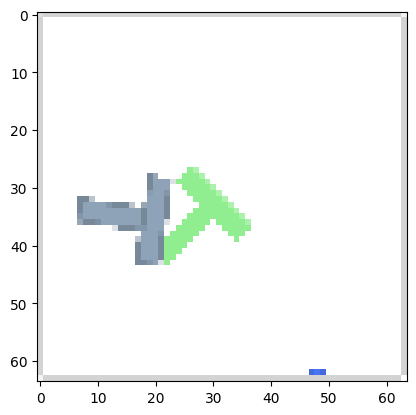

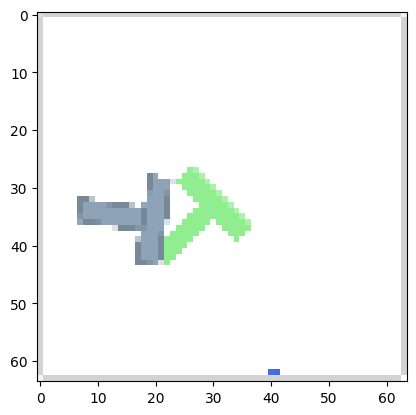

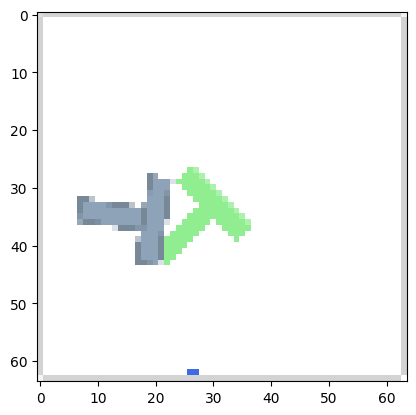

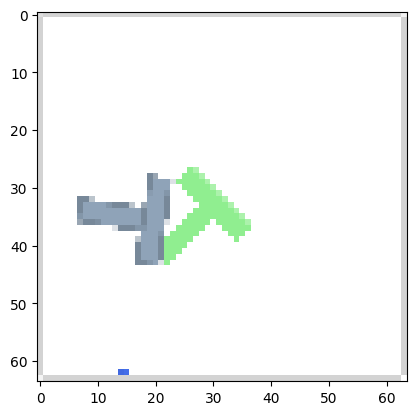

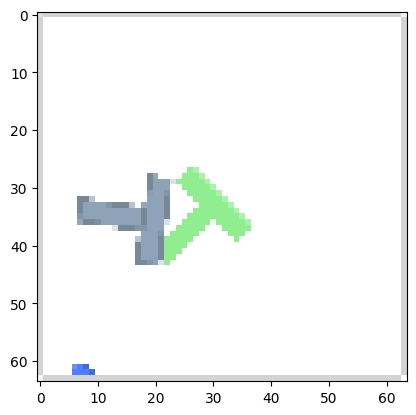

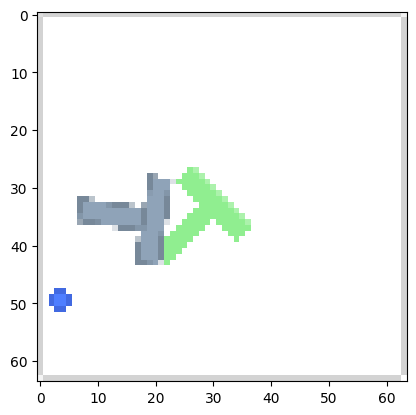

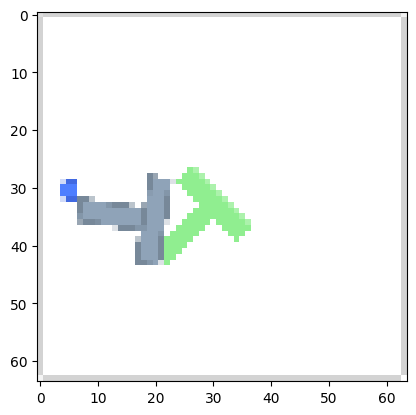

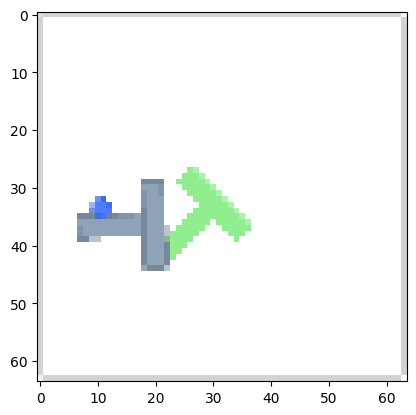

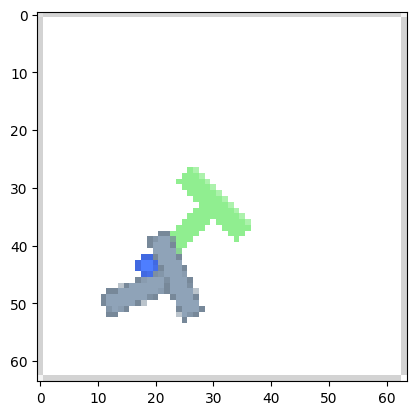

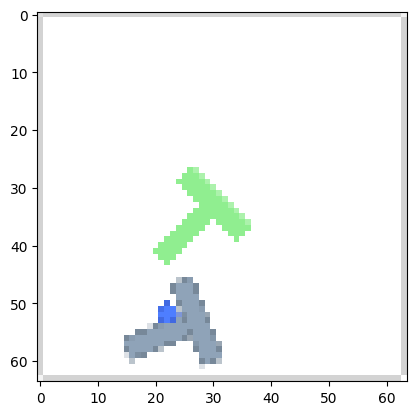

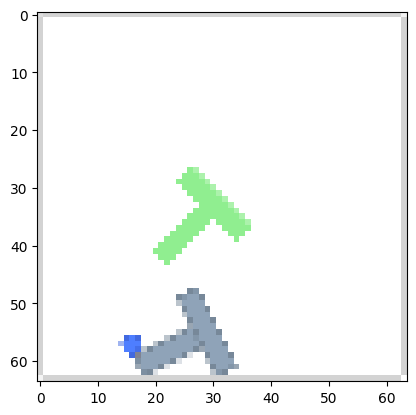

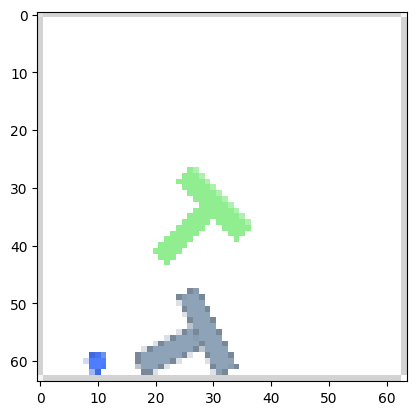

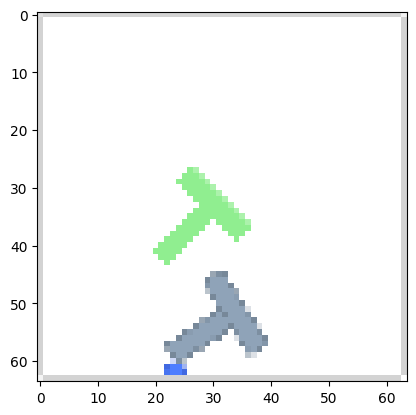

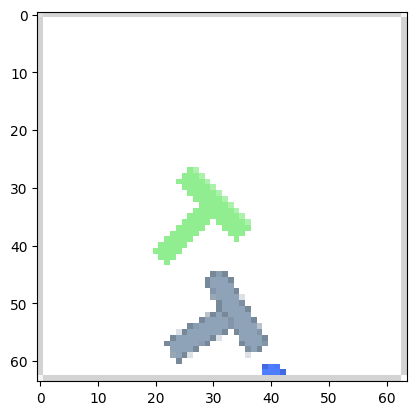

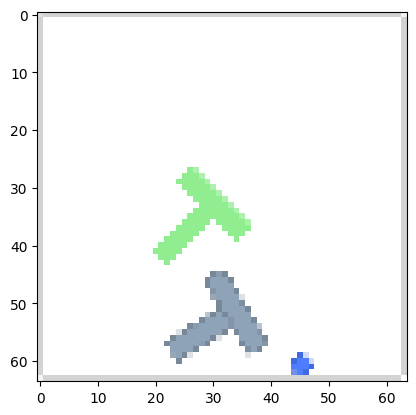

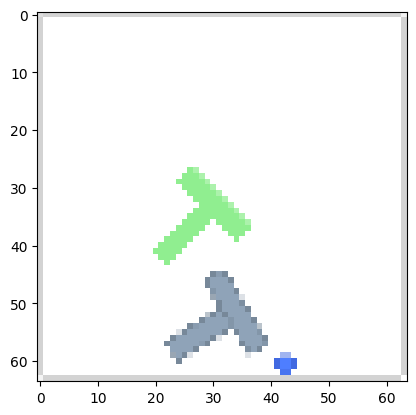

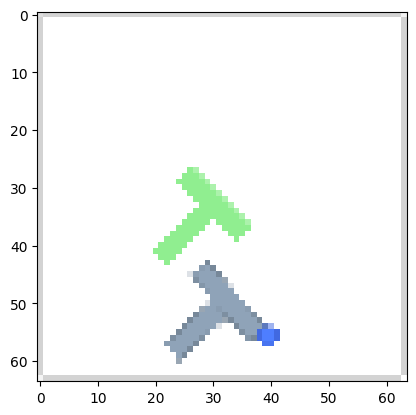

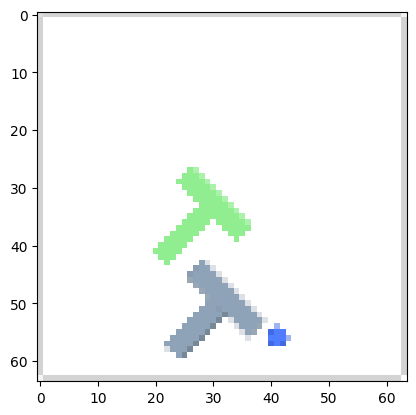

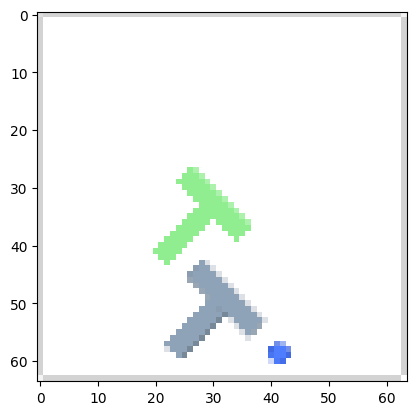

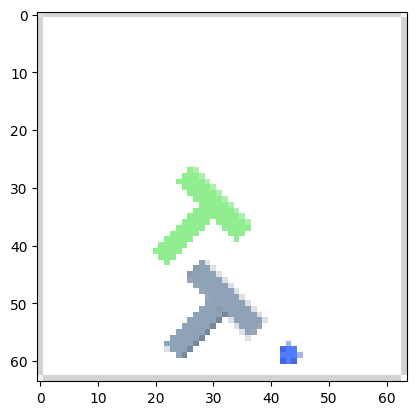

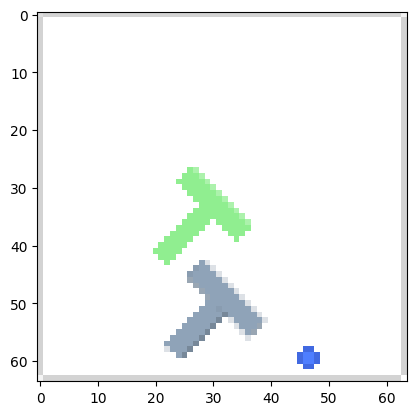

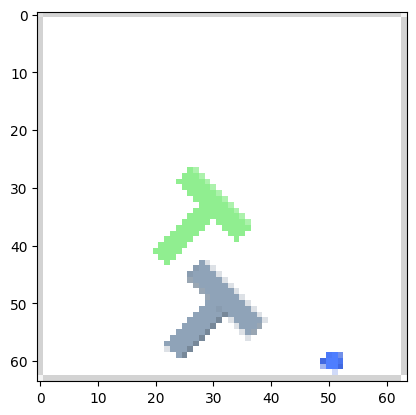

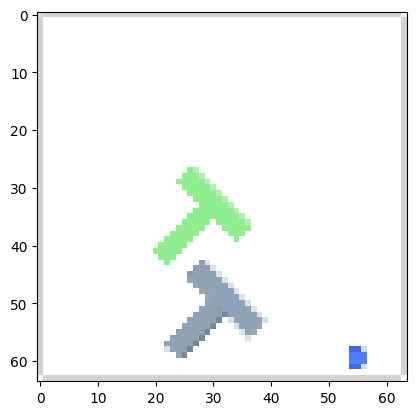

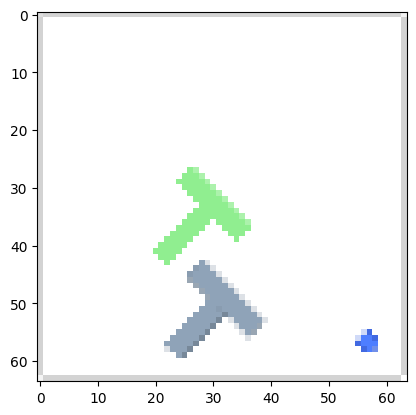

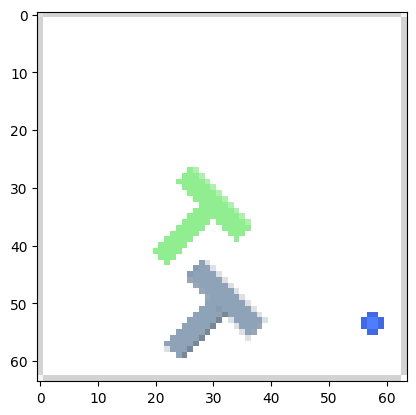

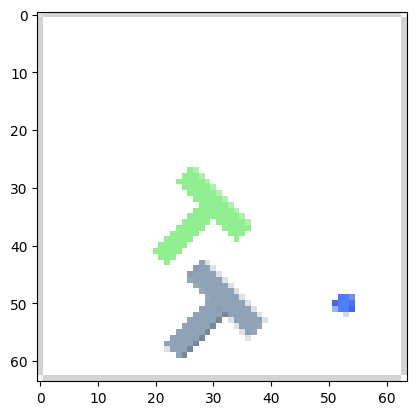

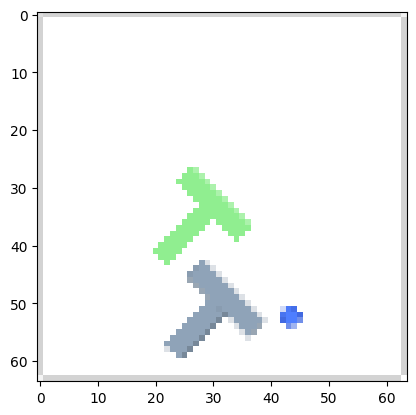

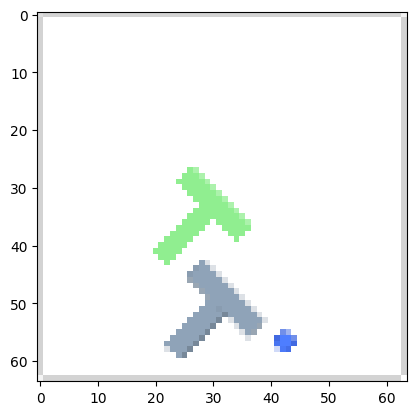

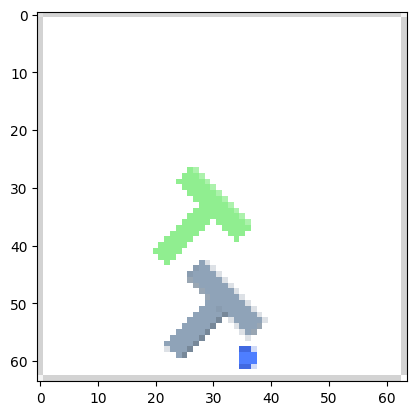

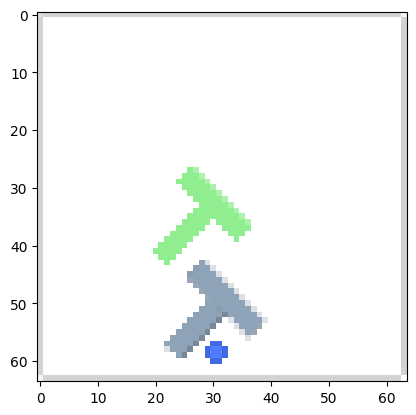

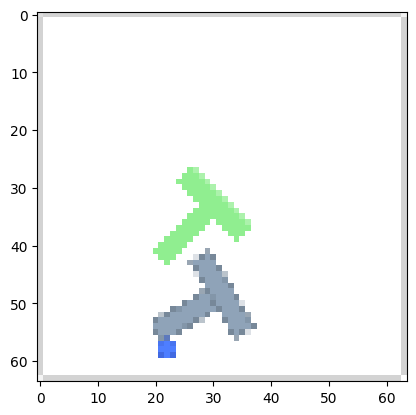

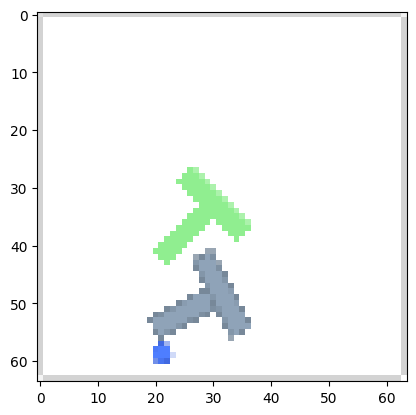

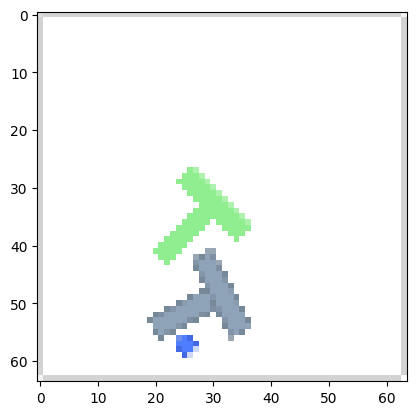

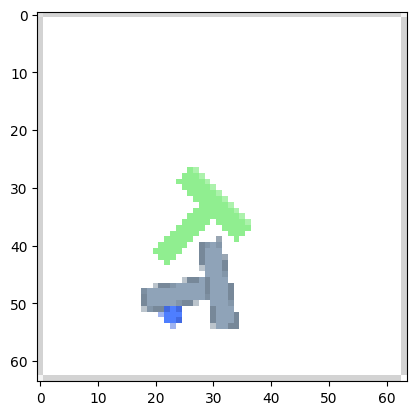

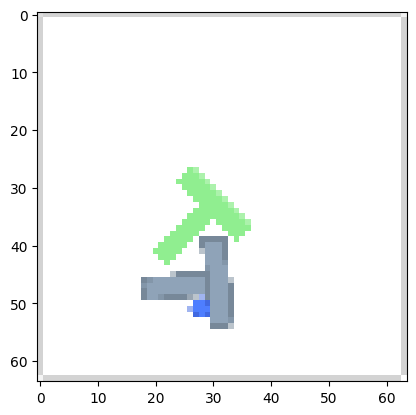

In [9]:
img = big_data_dict['image'][100]
from matplotlib import pyplot as plt
# img = np.random.random((64, 64, 3))
for img in big_data_dict['image'][:100]:
    plt.imshow(img, interpolation='nearest')
    plt.show()

# import cv2
# cv2.imshow


In [24]:
def fastrl_to_hf(big_data_dict, out_dir):
    video = False; fps = 20; video_path = None; debug = False
    ep_dicts = []
    episode_data_index = {"from": [], "to": []}

    id_from = 0
    id_to = 0
    ep_idx = 0
    data = big_data_dict
    total_frames = data["action"].shape[0]
# for i in tqdm.tqdm(range(total_frames)):
    for i in range(total_frames):
        id_to += 1

        if not data["is_terminal"][i]:
            continue

    # print("found terminal step")

        num_frames = id_to - id_from

        image = torch.tensor(data["image"][id_from:id_to])
    # image = einops.rearrange(image, "b h w c -> b h w c")
    # image = einops.rearrange(image, "b c h w -> b h w c")
        state = torch.tensor(data["state"][id_from:id_to, :2]) if ("state" in data) else torch.zeros(num_frames, 1)
    # state = torch.tensor(data["vector_state"][id_from:id_to]) if ("vector_state" in data) else torch.zeros(num_frames, 1)
        action = (torch.tensor(data["action"][id_from:id_to]) + 1) * 256
    # action = torch.tensor(data["action"][id_from:id_to])
    # TODO(rcadene): we have a missing last frame which is the observation when the env is done
    # it is critical to have this frame for tdmpc to predict a "done observation/state"
    # next_image = torch.tensor(data["next_observations"]["rgb"][id_from:id_to])
    # next_state = torch.tensor(data["next_observations"]["state"][id_from:id_to])
        next_reward = torch.tensor(data["reward"][id_from:id_to])
        next_done = torch.tensor(data["is_terminal"][id_from:id_to])

        ep_dict = {}

        imgs_array = [x.numpy() for x in image]
        img_key = "observation.image"
        if video:
        # save png images in temporary directory
            tmp_imgs_dir = out_dir / "tmp_images"
            tmp_imgs_dir.mkdir(parents=True, exist_ok=True)

            for i in range(len(imgs_array)):
                img = PILImage.fromarray(imgs_array[i])
                img.save(str(tmp_imgs_dir / f"frame_{i:06d}.png"), quality=100)

        # encode images to a mp4 video
            fname = f"{img_key}_episode_{ep_idx:06d}.mp4"
            video_path = out_dir / "videos" / fname
            encode_video_frames(tmp_imgs_dir, video_path, fps)

        # clean temporary images directory
            shutil.rmtree(tmp_imgs_dir)

        # store the reference to the video frame
            ep_dict[img_key] = [{"path": f"videos/{fname}", "timestamp": i / fps} for i in range(num_frames)]
        else:
        # ep_dict[img_key] = [PILImage.fromarray(x) for x in imgs_array]
            ep_dict[img_key] = imgs_array

        ep_dict["observation.state"] = state
        ep_dict["action"] = action
        ep_dict["episode_index"] = torch.tensor([ep_idx] * num_frames, dtype=torch.int64)
        ep_dict["frame_index"] = torch.arange(0, num_frames, 1)
        ep_dict["timestamp"] = torch.arange(0, num_frames, 1) / fps
    # ep_dict["next.observation.image"] = next_image
    # ep_dict["next.observation.state"] = next_state
        ep_dict["next.reward"] = next_reward
        ep_dict["next.done"] = next_done
        ep_dicts.append(ep_dict)

        episode_data_index["from"].append(id_from)
        episode_data_index["to"].append(id_from + num_frames)

        id_from = id_to
        ep_idx += 1

    # process first episode only
        if debug:
            break
    if len(ep_dicts) == 0:
        print("No terminal step found in the dataset")
    else:
        data_dict = concatenate_episodes(ep_dicts)
        data_dict, episode_data_index

        for k,v in data_dict.items():
            print(k, v.shape if hasattr(v, 'shape') else len(v))

        hf_dataset = to_hf_dataset(data_dict, video)

        info = {"fps": fps, "video": video}

        if video_path: 
            print(f"video path: {video_path}")
        lerobot_dataset = LeRobotDataset.from_preloaded(
            repo_id=env_name,
            hf_dataset=hf_dataset,
            episode_data_index=episode_data_index,
            info=info,
            videos_dir=video_path,
            )


        hf_dataset = hf_dataset.with_format(None)  # to remove transforms that cant be saved
        hf_dataset.save_to_disk(str(out_dir / "train"))
    print(lerobot_dataset)
    stats = compute_stats(lerobot_dataset, batch_size=16, num_workers=1)
    save_meta_data(info, stats, episode_data_index, out_dir / "meta_data")
    return stats

# stats = fastrl_to_hf(big_data_dict, out_dir)


In [26]:
# imis = [4, 5, 6, 7, 10] if AI else [3,4,5,6,7,8,9,10]
imis = [7]
for ai_tag in [True, False]:
    for imi in imis:
        files, out_dir = get_files(env_name, imi, AI=ai_tag)
        if files:
            big_data_dict = files_to_data_dict(files)
            print(f"Attempting to write to {out_dir}")
            stats = fastrl_to_hf(big_data_dict, out_dir)
            for k,v in stats.items():
                print(k, v)
        else: print(f"Could not find files for {imi}")

Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000036-a7db0fcfc37c4662a73a2d5fb4b7a675-57.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000018-19d0edad68584006892948523a58b976-47.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000036-5fdc796bb96445f18591238b305c5965-301.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000013-59336ccee68a49cba209f9c6f362bdbe-55.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000026-282d51313d674b469f44f4527957abd3-132.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000012-ccc02a021a2d47789ca14cb9b07bdafc-133.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000028-7400940190c747989fa51acdb1c660a0-301.npz
Processing /home/j/workspace/fastrl/logs/AD_pusht_4/final_eps_7/20240802T000040-573d1d08b531460fa915e3005f65f201-73.npz
Processing /home/j/workspace/fastrl/

Saving the dataset (1/1 shards): 100%|██████████| 37432/37432 [00:00<00:00, 189389.89 examples/s]


LeRobotDataset(
  Repository ID: 'pusht',
  Split: 'train',
  Number of Samples: 37432,
  Number of Episodes: 300,
  Type: image (.png),
  Recorded Frames per Second: 20,
  Camera Keys: ['observation.image'],
  Video Frame Keys: N/A,
  Transformations: None,
  Codebase Version: < v1.6,
)


Compute std: 100%|█████████▉| 2339/2340 [00:23<00:00, 97.60it/s] 


observation.image {'mean': tensor([[[0.9680]],

        [[0.9765]],

        [[0.9735]]]), 'std': tensor([[[0.1039]],

        [[0.0781]],

        [[0.0832]]]), 'max': tensor([[[1.]],

        [[1.]],

        [[1.]]]), 'min': tensor([[[0.2549]],

        [[0.3529]],

        [[0.3843]]])}
observation.state {'mean': tensor([244.2047, 312.8107]), 'std': tensor([163.9131, 155.1100]), 'max': tensor([511.9659, 511.9244]), 'min': tensor([0.0527, 0.1999])}
action {'mean': tensor([244.2879, 313.6606]), 'std': tensor([175.0396, 165.1467]), 'max': tensor([511.9999, 511.9998]), 'min': tensor([0.0008, 0.0042])}
episode_index {'mean': tensor([150.7273]), 'std': tensor([83.2624]), 'max': tensor([299.]), 'min': tensor([0.])}
frame_index {'mean': tensor([96.4410]), 'std': tensor([80.7925]), 'max': tensor([300.]), 'min': tensor([0.])}
timestamp {'mean': tensor([4.8220]), 'std': tensor([4.0396]), 'max': tensor([15.]), 'min': tensor([0.])}
next.reward {'mean': tensor([0.0067]), 'std': tensor([0.0818]),

Saving the dataset (1/1 shards): 100%|██████████| 5089/5089 [00:00<00:00, 146478.27 examples/s]

LeRobotDataset(
  Repository ID: 'pusht',
  Split: 'train',
  Number of Samples: 5089,
  Number of Episodes: 50,
  Type: image (.png),
  Recorded Frames per Second: 20,
  Camera Keys: ['observation.image'],
  Video Frame Keys: N/A,
  Transformations: None,
  Codebase Version: < v1.6,
)



Compute std: 100%|█████████▉| 318/319 [00:03<00:00, 86.74it/s]


observation.image {'mean': tensor([[[0.9681]],

        [[0.9763]],

        [[0.9738]]]), 'std': tensor([[[0.1039]],

        [[0.0786]],

        [[0.0824]]]), 'max': tensor([[[1.]],

        [[1.]],

        [[1.]]]), 'min': tensor([[[0.2549]],

        [[0.3529]],

        [[0.4157]]])}
observation.state {'mean': tensor([245.4221, 248.9852]), 'std': tensor([147.6809, 156.0525]), 'max': tensor([511.9644, 511.5482]), 'min': tensor([0.7840, 0.3993])}
action {'mean': tensor([245.0296, 250.2983]), 'std': tensor([165.7100, 169.6456]), 'max': tensor([511.9999, 511.9984]), 'min': tensor([0.0008, 0.0152])}
episode_index {'mean': tensor([26.1827]), 'std': tensor([13.9940]), 'max': tensor([49.]), 'min': tensor([0.])}
frame_index {'mean': tensor([70.7426]), 'std': tensor([63.0476]), 'max': tensor([300.]), 'min': tensor([0.])}
timestamp {'mean': tensor([3.5371]), 'std': tensor([3.1524]), 'max': tensor([15.]), 'min': tensor([0.])}
next.reward {'mean': tensor([0.0094]), 'std': tensor([0.0967]), '

Saving the dataset (1/1 shards): 100%|██████████| 5822/5822 [00:00<00:00, 102550.56 examples/s]

LeRobotDataset(
  Repository ID: 'pusht',
  Split: 'train',
  Number of Samples: 5822,
  Number of Episodes: 50,
  Type: image (.png),
  Recorded Frames per Second: 20,
  Camera Keys: ['observation.image'],
  Video Frame Keys: N/A,
  Transformations: None,
  Codebase Version: < v1.6,
)



Compute std: 100%|█████████▉| 363/364 [00:03<00:00, 92.57it/s]


observation.image {'mean': tensor([[[0.9691]],

        [[0.9765]],

        [[0.9749]]]), 'std': tensor([[[0.1020]],

        [[0.0785]],

        [[0.0798]]]), 'max': tensor([[[1.]],

        [[1.]],

        [[1.]]]), 'min': tensor([[[0.2549]],

        [[0.3529]],

        [[0.4157]]])}
observation.state {'mean': tensor([227.1472, 251.0406]), 'std': tensor([131.7354, 140.1943]), 'max': tensor([511.6476, 511.7238]), 'min': tensor([0.3784, 0.1999])}
action {'mean': tensor([227.1332, 251.9373]), 'std': tensor([144.3826, 152.3370]), 'max': tensor([511.9930, 511.9686]), 'min': tensor([0.0016, 0.0042])}
episode_index {'mean': tensor([25.2509]), 'std': tensor([13.3569]), 'max': tensor([49.]), 'min': tensor([0.])}
frame_index {'mean': tensor([95.7410]), 'std': tensor([82.6921]), 'max': tensor([300.]), 'min': tensor([0.])}
timestamp {'mean': tensor([4.7870]), 'std': tensor([4.1346]), 'max': tensor([15.]), 'min': tensor([0.])}
next.reward {'mean': tensor([0.0072]), 'std': tensor([0.0846]), '

Saving the dataset (1/1 shards): 100%|██████████| 5252/5252 [00:00<00:00, 105377.77 examples/s]

LeRobotDataset(
  Repository ID: 'pusht',
  Split: 'train',
  Number of Samples: 5252,
  Number of Episodes: 50,
  Type: image (.png),
  Recorded Frames per Second: 20,
  Camera Keys: ['observation.image'],
  Video Frame Keys: N/A,
  Transformations: None,
  Codebase Version: < v1.6,
)



Compute std: 100%|█████████▉| 328/329 [00:03<00:00, 89.63it/s]


observation.image {'mean': tensor([[[0.9672]],

        [[0.9762]],

        [[0.9726]]]), 'std': tensor([[[0.1052]],

        [[0.0784]],

        [[0.0851]]]), 'max': tensor([[[1.]],

        [[1.]],

        [[1.]]]), 'min': tensor([[[0.2549]],

        [[0.3529]],

        [[0.4157]]])}
observation.state {'mean': tensor([346.6174, 410.8414]), 'std': tensor([151.9930, 112.6268]), 'max': tensor([511.7449, 511.9244]), 'min': tensor([ 2.4006, 29.9876])}
action {'mean': tensor([346.9781, 412.5708]), 'std': tensor([161.7964, 121.7192]), 'max': tensor([511.9923, 511.9998]), 'min': tensor([0.0570, 0.1349])}
episode_index {'mean': tensor([23.1902]), 'std': tensor([14.8265]), 'max': tensor([49.]), 'min': tensor([0.])}
frame_index {'mean': tensor([84.0784]), 'std': tensor([77.2233]), 'max': tensor([300.]), 'min': tensor([0.])}
timestamp {'mean': tensor([4.2039]), 'std': tensor([3.8612]), 'max': tensor([15.]), 'min': tensor([0.])}
next.reward {'mean': tensor([0.0084]), 'std': tensor([0.0911]),

Saving the dataset (1/1 shards): 100%|██████████| 6574/6574 [00:00<00:00, 116604.52 examples/s]

LeRobotDataset(
  Repository ID: 'pusht',
  Split: 'train',
  Number of Samples: 6574,
  Number of Episodes: 50,
  Type: image (.png),
  Recorded Frames per Second: 20,
  Camera Keys: ['observation.image'],
  Video Frame Keys: N/A,
  Transformations: None,
  Codebase Version: < v1.6,
)



Compute std: 100%|█████████▉| 410/411 [00:04<00:00, 84.39it/s]

observation.image {'mean': tensor([[[0.9673]],

        [[0.9762]],

        [[0.9732]]]), 'std': tensor([[[0.1055]],

        [[0.0789]],

        [[0.0840]]]), 'max': tensor([[[1.]],

        [[1.]],

        [[1.]]]), 'min': tensor([[[0.2549]],

        [[0.3529]],

        [[0.3843]]])}
observation.state {'mean': tensor([287.5931, 321.1634]), 'std': tensor([120.2360, 111.6303]), 'max': tensor([511.9659, 511.6976]), 'min': tensor([0.1235, 7.4525])}
action {'mean': tensor([288.1484, 322.1915]), 'std': tensor([143.1989, 133.0367]), 'max': tensor([511.9990, 511.9983]), 'min': tensor([0.0058, 0.0451])}
episode_index {'mean': tensor([23.4405]), 'std': tensor([14.8900]), 'max': tensor([49.]), 'min': tensor([0.])}
frame_index {'mean': tensor([88.3248]), 'std': tensor([69.4648]), 'max': tensor([300.]), 'min': tensor([0.])}
timestamp {'mean': tensor([4.4162]), 'std': tensor([3.4732]), 'max': tensor([15.]), 'min': tensor([0.])}
next.reward {'mean': tensor([0.0073]), 'std': tensor([0.0851]), '

In [70]:

# from datasets import load_dataset, load_from_disk
# loaded_dataset = load_from_disk(str(out_dir / "train"))

# dataloader = torch.utils.data.DataLoader(
#     loaded_dataset,
#     num_workers=1,
#     batch_size=2,
#     shuffle=False,
# )

# batch = next(iter(dataloader))